In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install tensorflow tensorflow-io matplotlib

In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

In [6]:
CAPUCHIN_FILE = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')                                  # Capuchin Bird File Path
NOT_CAPUCHIN_FILE = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [7]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [8]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

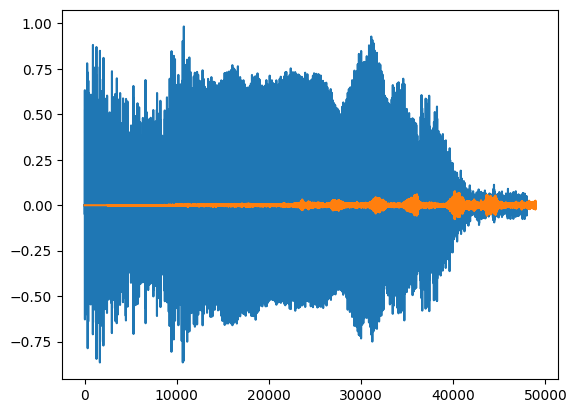

In [9]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [13]:
POS = os.path.join('/kaggle/input','z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Capuchinbird_Clips')     # positive path / capuchin bird
NEG = os.path.join('/kaggle/input','z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Not_Capuchinbird_Clips')

In [14]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [15]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [17]:
lengths = []
for file in os.listdir(os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [18]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [19]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [20]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [21]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [22]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [23]:
spectrogram, label = preprocess(filepath, label)

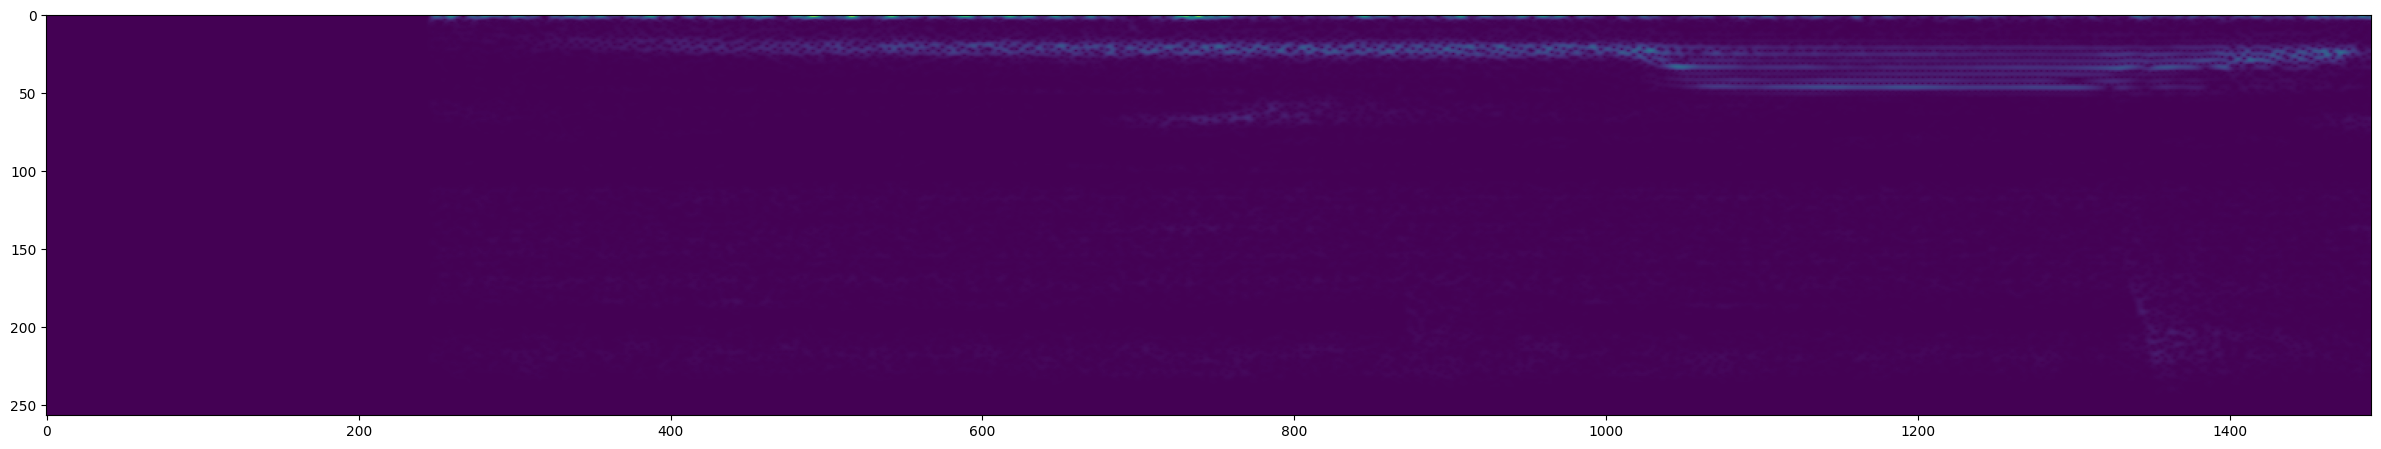

In [24]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [25]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [26]:
train = data.take(36)
test = data.skip(36).take(15)

In [27]:
samples, labels = train.as_numpy_iterator().next()

In [28]:
samples.shape

(16, 1491, 257, 1)

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [30]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770482865 (2.87 GB)
Trainable params: 770482865 (2.87 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 431s 12s/step - loss: 8.8999 - recall: 0.8562 - precision: 0.8188 - val_loss: 0.1220 - val_recall: 0.9692 - val_precision: 0.9692
Epoch 2/4
36/36 [==============================] - 428s 12s/step - loss: 0.0972 - recall: 0.9551 - precision: 0.9613 - val_loss: 0.1258 - val_recall: 0.9667 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 440s 12s/step - loss: 0.0801 - recall: 0.9742 - precision: 0.9805 - val_loss: 0.0086 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 409s 11s/step - loss: 0.0049 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0023 - val_recall: 1.0000 - val_precision: 1.0000


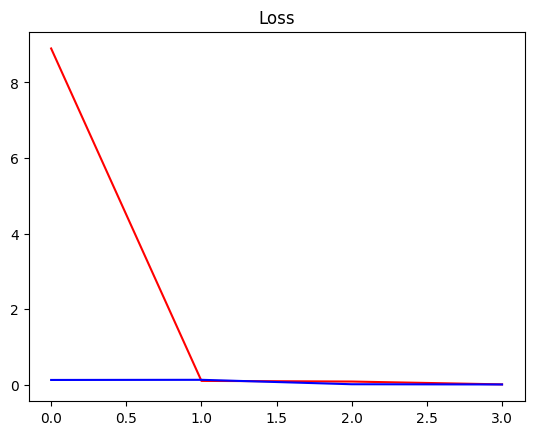

In [34]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()


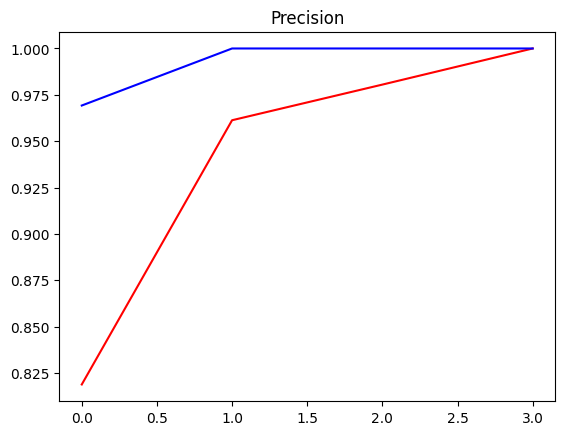

In [35]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

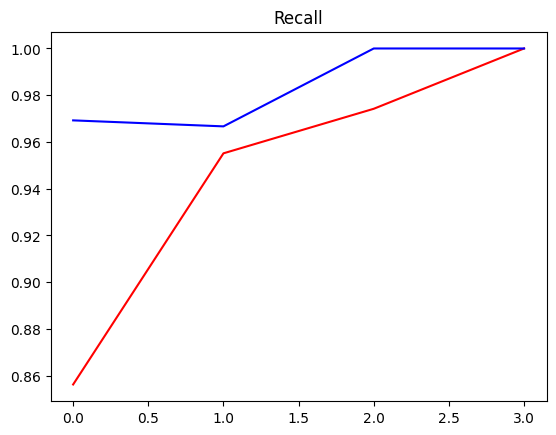

In [36]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [37]:
X_test, y_test = test.as_numpy_iterator().next()

In [38]:
yhat = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


In [39]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [40]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [43]:
mp3 = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings', 'recording_08.mp3')

In [44]:
wav = load_mp3_16k_mono(mp3)

In [45]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [46]:
samples, index = audio_slices.as_numpy_iterator().next()

In [47]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [48]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [49]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

3/3 [==============================] - 17s 4s/step


In [50]:
from itertools import groupby

In [51]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [52]:
calls

25

In [56]:
results = {}
for file in os.listdir(os.path.join('../input','z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings')):
    FILEPATH = os.path.join('../input','z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

1/1 [==============================] - 5s 5s/step


In [57]:
results

{'recording_76.mp3': array([[2.29596756e-02],
        [1.11903525e-07],
        [1.50202259e-01],
        [1.85231015e-01],
        [1.41351894e-01],
        [1.61740512e-01],
        [1.83991849e-01],
        [1.53555691e-01],
        [1.14628114e-01],
        [2.14461580e-01],
        [2.56260663e-01],
        [3.15757304e-01],
        [3.16794187e-01],
        [1.69083774e-01],
        [1.69909179e-01],
        [2.80095160e-01],
        [2.49582052e-01],
        [2.04401404e-01],
        [1.04315147e-01],
        [1.29194246e-04],
        [5.64217553e-05],
        [5.76906405e-06],
        [1.23408716e-03],
        [5.35238655e-07],
        [5.88787134e-06],
        [7.32960605e-20],
        [3.02369078e-14],
        [6.00296244e-06],
        [4.08089598e-08],
        [1.83954444e-06],
        [1.45107513e-19],
        [3.08112114e-08],
        [9.99988556e-01],
        [1.25729982e-10],
        [7.02058429e-08],
        [1.72748923e-06],
        [1.22601637e-06],
        [1.0604481

In [58]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_76.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_62.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_48.mp3': [0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_44.mp3': [0,
  0,
  0,
  

In [59]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_76.mp3': 1,
 'recording_62.mp3': 0,
 'recording_48.mp3': 4,
 'recording_44.mp3': 1,
 'recording_45.mp3': 5,
 'recording_06.mp3': 5,
 'recording_43.mp3': 5,
 'recording_68.mp3': 1,
 'recording_95.mp3': 5,
 'recording_17.mp3': 3,
 'recording_65.mp3': 5,
 'recording_74.mp3': 0,
 'recording_10.mp3': 5,
 'recording_49.mp3': 0,
 'recording_15.mp3': 2,
 'recording_37.mp3': 5,
 'recording_64.mp3': 2,
 'recording_39.mp3': 10,
 'recording_04.mp3': 4,
 'recording_28.mp3': 14,
 'recording_05.mp3': 0,
 'recording_80.mp3': 1,
 'recording_57.mp3': 3,
 'recording_12.mp3': 2,
 'recording_59.mp3': 12,
 'recording_67.mp3': 0,
 'recording_09.mp3': 0,
 'recording_79.mp3': 0,
 'recording_14.mp3': 0,
 'recording_63.mp3': 16,
 'recording_86.mp3': 15,
 'recording_47.mp3': 18,
 'recording_03.mp3': 0,
 'recording_33.mp3': 0,
 'recording_08.mp3': 25,
 'recording_51.mp3': 5,
 'recording_35.mp3': 0,
 'recording_81.mp3': 5,
 'recording_30.mp3': 3,
 'recording_88.mp3': 0,
 'recording_75.mp3': 1,
 'recordi

In [60]:
import csv

In [61]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])